**MÔ HÌNH CNN**

In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import string
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from google.colab import drive
# mount drive
drive.mount('/content/drive')
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential

ValueError: mount failed

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)
path = '/content/drive/MyDrive/ HOC/AI/CNN/data2'

train_generator = train_datagen.flow_from_directory(
        path+'/training_data',  # this is the target directory
        target_size=(28,28),  # tất cả các hình ảnh sẽ được thay đổi kích thước thành 28x28,, batch_size=1
        batch_size=32,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
    path+'/testing_data',  # cùng thư mục với train
    target_size=(28,28),    # tất cả các hình ảnh sẽ được thay đổi kích thước thành 28x28
    batch_size=32,
    class_mode='sparse')

In [ ]:
import tensorflow as tf

# Định nghĩa lớp F1Score
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Chuyển y_true và y_pred sang định dạng phù hợp
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.cast(y_true, tf.int64)

        # Cập nhật các giá trị TP, FP, FN
        self.tp.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32)))
        self.fp.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 1)), tf.float32)))
        self.fn.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 0)), tf.float32)))

    def result(self):
        # Tính toán precision, recall, và F1-score
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        # Đặt lại các giá trị
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)


# # Định nghĩa mô hình của bạn
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(784,)),  # Sử dụng Input thay vì input_shape
#     tf.keras.layers.Dense(128, activation='relu'),  # Lớp ẩn
#     tf.keras.layers.Dense(36, activation='softmax')  # Lớp đầu ra
# ])

# # Biên dịch mô hình với F1Score làm metric
# model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=[F1Score()]  # Thêm metric F1-score
# )

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from keras import optimizers

model = Sequential([

    Conv2D(16, (22, 22), input_shape=(28, 28, 3), activation='relu', padding='same'),
    Conv2D(32, (16, 16), activation='relu', padding='same'),  # Không cần input_shape
    Conv2D(64, (8, 8), activation='relu', padding='same'),
    Conv2D(64, (4, 4), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(36, activation='softmax')  # Đầu ra từ 0-9 và các ký tự từ A-Z
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=[F1Score()]
)

In [ ]:
model.summary()

In [ ]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Kiểm tra nếu 'val_custom_f1score' có trong logs
        if logs.get('val_custom_f1score') and logs['val_custom_f1score'] > 0.99:
            print(f"Stopping training as val_custom_f1score > 0.99 at epoch {epoch}")
            self.model.stop_training = True

In [ ]:
# Huấn luyện mô hình
batch_size = 32
callbacks = [stop_training_callback()]
history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      epochs = 20, verbose=1, callbacks=[stop_training_callback()])

NameError: name 'stop_training_callback' is not defined

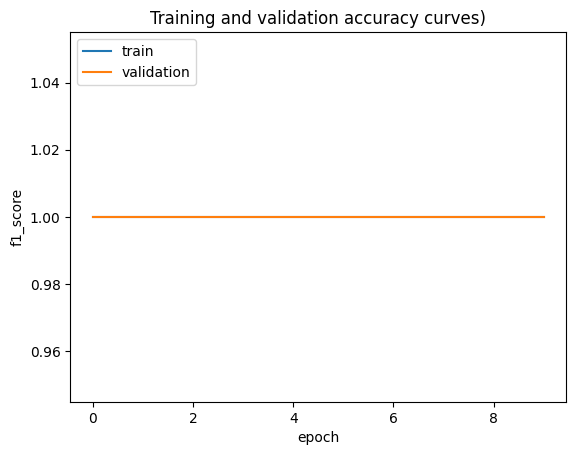

In [ ]:
# Tỷ lệ F1-scroe
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Training and validation accuracy curves)')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

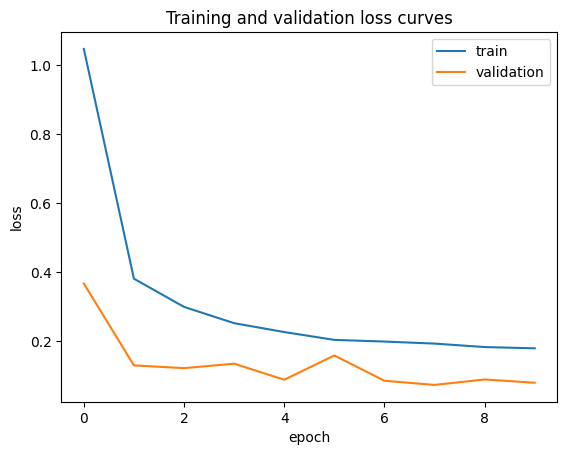

In [ ]:
# Tỷ lệ loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#Lưu mô hình
model.save('/content/drive/MyDrive/ HOC/AI/BTL/CODE_CNN/my_model.h5')